In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from astropy import constants as cste

#%matplotlib widget

## Numerical integration scheme

In [2]:
def glf(N, F, P, i):
    glf_f, glf_p = [], []
    for j in range(0,n_cell):
            if i == 0 and j == 0:
                glf_f.append(0)
                glf_p.append(0)
            if i != 0 and j == 0:
                glf_f.append( (F[i - 1][n_cell - 1] + F[i][j]) * 0.5 - c/2 * (N[i][j] - N[i - 1][n_cell - 1]) )
                glf_p.append( (P[i - 1][n_cell - 1] + P[i][j]) * 0.5 - c/2 * (F[i][j] - F[i - 1][n_cell - 1]) )
            if j != 0:
                glf_f.append( (F[i][j - 1] + F[i][j]) * 0.5 - c/2 * (N[i][j] - N[i][j - 1]) )
                glf_p.append( (P[i][j - 1] + P[i][j]) * 0.5 - c/2 * (F[i][j] - F[i][j - 1]) )
                
    return glf_f, glf_p

In [274]:
def numerical_scheme(n_photon, N, F, P, T, dt, tf, source_pos, X, continuous=True, chemistery=True, coupling=True):
    kb = cste.k_B.value
    for i in source_pos:
        N[0][i] = n_photon
    
    for i in range(0,int(tf/dt)-1):
        GLF = glf(N,F,P,i)
        glf_f, glf_p = GLF[0], GLF[1]
        
        for k in range(0,n_cell):
            if continuous == True and (k in source_pos):
                if k < n_cell - 1:
                    N[i + 1][k] = n_photon + N[i][k] - dt/dx * (glf_f[k + 1] - glf_f[k])
                    F[i + 1][k] = F[i][k] - dt/dx * (glf_p[k + 1] - glf_p[k])
                else:
                    N[i + 1][k] = n_photon + N[i][k] - dt/dx * (glf_f[0] - glf_f[k])
                    F[i + 1][k] = F[i][k] - dt/dx * (glf_p[0] - glf_p[k])
                    
            else: 
                if k < n_cell - 1:
                    N[i + 1][k] = N[i][k] - dt/dx * (glf_f[k + 1] - glf_f[k])
                    F[i + 1][k] = F[i][k] - dt/dx * (glf_p[k + 1] - glf_p[k])
                else:
                    N[i + 1][k] = N[i][k] - dt/dx * (glf_f[0] - glf_f[k])
                    F[i + 1][k] = F[i][k] - dt/dx * (glf_p[0] - glf_p[k])
                    
            if N[i + 1][k] < 1e-25:
                N[i + 1][k] = 0.0001

            if chemistery == True:
                X[i + 1][k] = third_order_polynom(X[i][k], rho, sigma, N[i + 1][k], T[i + 1][k],c)
                test = new_advection_equation(N[i + 1][k], F[i + 1][k], rho, X[i+1][k], X[i][k], T[i + 1][k])
                N[i + 1][k] = test[0]
                F[i + 1][k] = test[1]

            f = F[i + 1][k] / (c * N[i + 1][k])
            chi = (3 + 4 * (f**2)) / (5 + 2 * np.sqrt(4 - 3 * (f**2)))
            P[i + 1][k] = chi * N[i + 1][k] * (c**2)
            
            
            if coupling == True:
                T[i + 1][k] = (2*dt*(heating(rho,dx,E_photon,X[i + 1][k],X[i][k])-cooling(T[i][k]))
                               +T[i][k]*(3*rho*(1-X[i + 1][k])*kb))/((3*rho*(1-X[i + 1][k])*kb)
                                                                 + dt*2*(3/2*rho*(1-X[i + 1][k])*kb*(X[i + 1][k]-X[i][k]))/dt)
            
        if i%5000 == 0:
            print(i)
                
                
    return N, F, P, T, X

In [255]:
heating(3, 1.9285e19, 20, 0.0013, 0.0012)

2.203333009651201e+36

In [244]:
3 * 1.9285e19 * 1.9285e19* 1.9285e19 * 6.4 * 1.6e-19

2.2033330096512e+40

In [252]:
cooling(2000)

1.314236719790251e-51

## Hydrogen photo-ionization

In [256]:
def alpha(T):
    Lambda = (2*157807)/T
    res    = 1.269e-13
    res   *= pow(Lambda, 1.503)
    res   /= pow(1 + (Lambda/0.522)**0.47, 1.923)
    return res

def alpha_b(T):
    Lambda = (2*157807)/T
    res    = 2.753e-14
    res   *= pow(Lambda, 1.5)
    res   /= pow(1 + (Lambda/2.74)**0.407, 2.242)
    return res

def beta(T):
    Lambda = (2*157807)/T
    res    = 21.11*pow(T, (-3/2))*np.exp(-Lambda/2)*pow(Lambda, -1.089)
    res   /=pow(1 + pow(Lambda/0.354, 0.874), 1.01)
    return res

In [257]:
def cooling(T): #collisional excitation cooling in erg cm^3 s^-1
    res  = 7.5e-19/(1.+pow(T/1.0e5,0.5))
    res *= np.exp(-118348./T)
    return res * 1e-7

def heating(rho, dx, E_photon, X, x): 
    E_ionisation = 13.6
    N_tot = rho*(dx*dx*dx)
    E_thermal = N_tot*(X-x)*(E_photon - E_ionisation)
    return E_thermal * 1.6e-19

In [258]:
def third_order_polynom(x, rho, sigma, N, T, c):
    m = (alpha_b(T) + beta(T)) * (rho**2) * dt
    n = rho - ((alpha(T) + beta(T)) * rho)/(sigma*c) - alpha_b(T) * (rho**2) * dt - 2 * beta(T) * (rho**2) * dt
    p = -rho * (1 + x) - N - 1/(sigma * c * dt) + (beta(T) * rho)/(sigma * c) + beta(T) * (rho**2) * dt
    q = N + rho * x + x/(sigma * c * dt)

    root = np.roots((m,n,p,q))
    for i in root:
        if i > 0 and i < 1:
            sol = i
    
    return sol

In [259]:
def new_advection_equation(N_explicit, F_explicit, rho, X, x, T):
    N = N_explicit + beta(T)*(rho**2)*(1 - X)*X*dt - alpha_b(T)*(rho**2)*(X**2)*dt - rho*(X-x)
    F = F_explicit / (1 + c*sigma*rho*dt*(1 - X))

    return N, F

## main

In [267]:
n_photon = 5e48 #number of photon per second

sigma = 1.63e-18
dt = 1e8
tf = 1e10
rho = 6
Tt = 2e3
X = 0.0012


n_cell = 61
dx = 1.9285e19
L = n_cell*dx
c = cste.c.value*1e2

n_gamma = (n_photon)*dt/(dx*dx*dx)


e_thermal = (20 - 13.6)*1.6e-19
rho_cell = rho * (dx*dx*dx)

E_photon = 20 #eV

In [268]:
source_pos = [int(n_cell/2)]
N, F, P, T, x = [], [], [], [], []

for i in range(int(tf/dt)):
    N.append(np.zeros(n_cell))
    F.append(np.zeros(n_cell))
    P.append(np.zeros(n_cell))
    T.append(np.ones(n_cell)*Tt)
    x.append(np.ones(n_cell)*X)

In [269]:
L = (n_gamma*dx)/(alpha_b(Tt)*(rho**2)*dx*dt)
L

21.253877779846096

In [270]:
L*6.25

132.8367361240381

In [271]:
(c*dt)/dx

0.1554536987295826

In [265]:
b = numerical_scheme(n_gamma,N,F,P,T,dt,tf,source_pos,x,continuous=True,chemistery=True,coupling=True)

0


In [272]:
a = numerical_scheme(n_gamma,N,F,P,T,dt,tf,source_pos,x,continuous=True,chemistery=True,coupling=False)

0


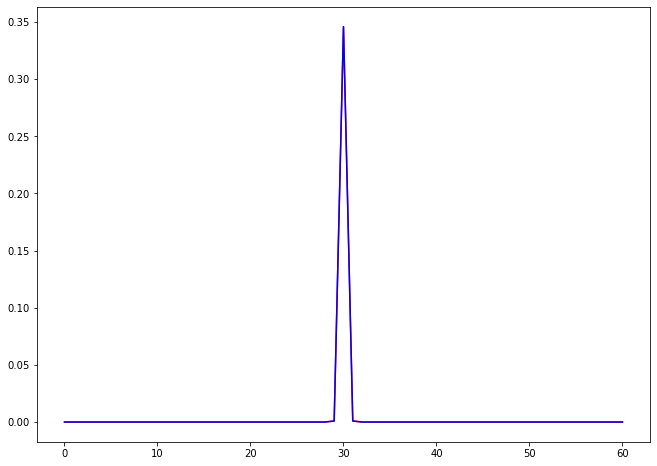

In [273]:
plt.figure(figsize=(11,8))
plt.plot(b[0][-1],c='r')
plt.plot(a[0][-1],c='b')
plt.show()

In [240]:
b[3][1]

array([5.72202389e+65, 5.72202389e+65, 5.72202389e+65, 5.72202389e+65,
       5.72202389e+65, 5.72202389e+65, 5.72202389e+65, 5.72202389e+65,
       5.72202389e+65, 5.72202389e+65, 5.72202389e+65, 5.72202389e+65,
       5.72202389e+65, 5.72202389e+65, 5.72202389e+65, 5.72202389e+65,
       5.72202389e+65, 5.72202389e+65, 5.72202389e+65, 5.72202389e+65,
       5.72202389e+65, 5.72202389e+65, 5.72202389e+65, 5.72202389e+65,
       5.72202389e+65, 5.72202389e+65, 5.72202389e+65, 5.72202389e+65,
       5.72202389e+65, 3.10056734e+67, 7.35632376e+68, 3.10056734e+67,
       5.72202389e+65, 5.72202389e+65, 5.72202389e+65, 5.72202389e+65,
       5.72202389e+65, 5.72202389e+65, 5.72202389e+65, 5.72202389e+65,
       5.72202389e+65, 5.72202389e+65, 5.72202389e+65, 5.72202389e+65,
       5.72202389e+65, 5.72202389e+65, 5.72202389e+65, 5.72202389e+65,
       5.72202389e+65, 5.72202389e+65, 5.72202389e+65, 5.72202389e+65,
       5.72202389e+65, 5.72202389e+65, 5.72202389e+65, 5.72202389e+65,
      

In [213]:
a[3][-1]

array([2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000.])

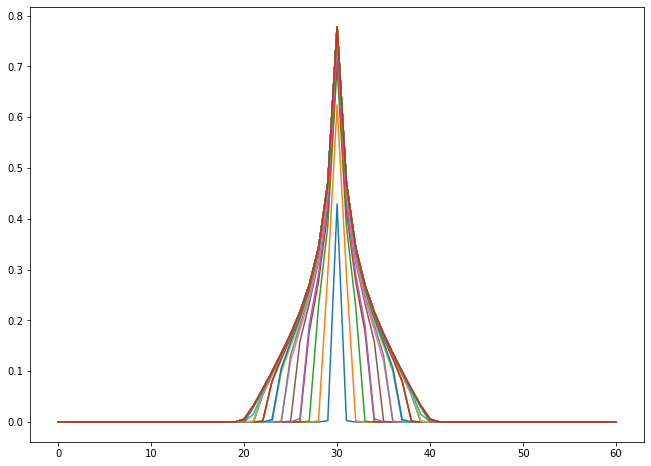

In [185]:
plt.figure(figsize=(11,8))
for i in range(int(tf/dt)-1):
    if i%200 == 0 and i!=0:
        plt.plot(b[0][i])
#plt.savefig("photon_density.png")
plt.show()

In [182]:
print((b[3][-1]))

[7.29944946e+66 3.59326754e+65 3.34848433e+65 3.34748664e+65
 3.34748243e+65 3.34748241e+65 3.34748241e+65 3.34748241e+65
 3.34748241e+65 3.34748241e+65 3.34748241e+65 3.34748241e+65
 3.34748241e+65 3.34748242e+65 3.34748266e+65 3.34753930e+65
 3.35953899e+65 5.90804092e+65 5.65094988e+67 9.49900317e+69
 1.04292718e+71 1.62307178e+71 1.87659533e+71 2.04072634e+71
 2.16652437e+71 2.27312672e+71 2.37085469e+71 2.46800137e+71
 2.57523569e+71 2.71609820e+71 3.10872323e+71 2.71609820e+71
 2.57523569e+71 2.46800137e+71 2.37085469e+71 2.27312672e+71
 2.16652437e+71 2.04072634e+71 1.87659533e+71 1.62307178e+71
 1.04292718e+71 9.49900317e+69 5.65094988e+67 5.90804092e+65
 3.35953899e+65 3.34753930e+65 3.34748266e+65 3.34748242e+65
 3.34748241e+65 3.34748241e+65 3.34748241e+65 3.34748241e+65
 3.34748241e+65 3.34748241e+65 3.34748241e+65 3.34748243e+65
 3.34748664e+65 3.34848435e+65 3.59327036e+65 7.29952566e+66
 2.15750409e+69]


In [ ]:
# diffusion numérique -> un peu photons loin
#lissage par GLF du dirac -> front d'onde theorique suit pas excatement la simu 

In [14]:
324077928963.48486328

324077928963.48486

In [ ]:
XAxis = np.arange(n_cell)
fig, ax = plt.subplots()

def animate(i):
    #a[0][i] = np.amax(a[0][i])
    ax.clear()
    ax.set_ylim(0, np.amax(a[0][i]))
    line, = ax.plot(XAxis, a[0][i], c='red')
    line1, = ax.plot(XAxis, b[0][i], c='blue')
    return line, line1,

ani = FuncAnimation(fig, animate, interval = 0.1, blit=True, repeat=True, frames=1000)
ani.save("Gngn.gif", dpi = 300, writer = PillowWriter(fps=25))